In [1]:
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import torch
import csv
from torch.utils.data import DataLoader, Dataset
import math
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\10298\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 输入数据进行处理

In [2]:
path=r"D:\Project\Xiehe_Spinal_image_stitching\cobb\ke30_u7_AASCE2019-master\boostnet_labeldata"
path_heatmap=r'D:\Project\Xiehe_Spinal_image_stitching\cobb\codes\Heatmap'
class CenterNetDataset(Dataset):
    def __init__(self, path, train=True,transform_img=None,transform_label=None):
        self.names = []
        self.labels = []
        self.heatmap_names=[]
        self.scale=4#heatmap的缩放倍数
        self.transform_img=transform_img
        self.transform_label=transform_label
        self.train=train
        if train:
            image_path = path + "/data/training_preprocessed/"
            heatmaps_path = path_heatmap+"/training/"
            names = csv.reader(open(path + "/labels/training/filenames.csv", 'r'))
            names=list(names)
            self.names=[image_path+n[0] for n in names]
            self.heatmap_names=[heatmaps_path+n[0] for n in names]
            landmarks = csv.reader(open(path + "/labels/training/landmarks.csv", 'r'))
        else:
            image_path = path + "/data/test_preprocessed/"
            heatmaps_path = path_heatmap+"/test/"
            names = csv.reader(open(path + "/labels/test/filenames.csv", 'r'))
            names=list(names)
            self.names=[image_path+n[0] for n in names]
            self.heatmap_names=[heatmaps_path+n[0] for n in names]
            landmarks = csv.reader(open(path + "/labels/test/landmarks.csv", 'r'))
        
        for landmark_each_image in landmarks:#地标
            coordinate_list = []
            for coordinate in landmark_each_image:
                coordinate_list.append(float(coordinate))
            self.labels.append((coordinate_list))

    def pad_img(self,img): 
          
        h,w,_=img.shape
        h_max=3840
        w_max=1536
        top = math.floor((h_max - h)/2)
        bottom = round((h_max - h)/2+0.1)
        left = math.floor((w_max - w) / 2)
        right = round((w_max - w) / 2+0.1)#四舍五入
        image_padded = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        
        return image_padded

    
    def __getitem__(self, index):
        image_name = self.names[index]
        label = self.labels[index]
        heatmap_name=self.heatmap_names[index]
        origin_image = cv2.imread(image_name)
        image_padded=self.pad_img(origin_image)

        target_height = image_padded.shape[0]//4 # 3840/4=960 缩小原图输入
        target_width =image_padded.shape[1]//4 # 1536/4=384
        image_resize=cv2.resize(image_padded, (target_width, target_height))#结果存在image
        heatmap = cv2.imread(heatmap_name,0)
        
        # heatmap_resize=cv2.resize(heatmap_padded ,(target_width//self.scale,target_height//self.scale)) #960/4=240 ,384/4=96缩小heatmap输入
        
        if self.transform_img:
            image_resize = self.transform_img(image_resize)
            heatmap=self.transform_label(heatmap)
            heatmap=np.expand_dims(heatmap, axis=2)
        image_resize = torch.tensor(image_resize, dtype=torch.float32)
        heatmap = torch.tensor(heatmap, dtype=torch.float32)

        if self.train:
            return origin_image.shape,image_resize,label,heatmap,image_name
        else:
            return origin_image,image_resize,label,heatmap,image_name
        
        
    def __len__(self):
        return len(self.names)



### Loss computation
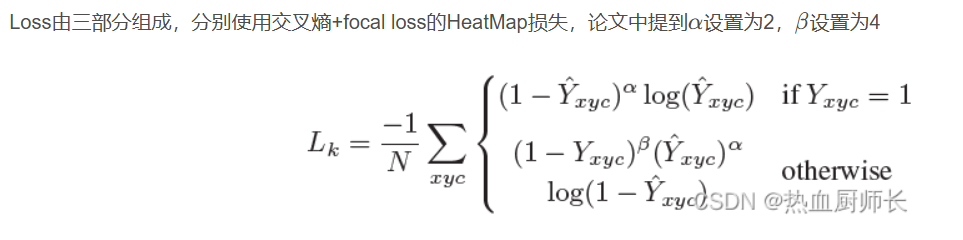

In [3]:
def focal_loss(pred, target):
    """
    classifier loss of focal loss
    Args:
        pred: heatmap of prediction
        target: heatmap of ground truth

    Returns: cls loss

    """
    # Find every image positive points and negative points,
    # one bounding box corresponds to one positive point,
    # except positive points, other feature points are negative sample.
    pos_inds = target.eq(1).float()#=1
    neg_inds = target.lt(1).float()#<1

    # The negative samples near the positive sample feature point have smaller weights
    neg_weights = torch.pow(1 - target, 4)
    loss = 0
    pred = torch.clamp(pred, 1e-6, 1 - 1e-6)

    # Calculate Focal Loss.
    # The hard to classify sample weight is large, easy to classify sample weight is small.
    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_inds * neg_weights##和上面的公式对应

    # Loss normalization is carried out
    num_pos = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos

    return loss

def l1_loss(pred, target, mask):
    """
    Calculate l1 loss
    Args:
        pred: offset detection result
        target: offset ground truth
        mask: offset mask, only center point is 1, other place is 0

    Returns: l1 loss

    """
    

    # Don't calculate loss in the position without ground truth.
    loss = F.l1_loss(pred * mask, target * mask, reduction='sum')

    loss = loss / (mask.sum() + 1e-7)

    return loss

def l2_loss(pred, target):
    return F.mse_loss(pred, target, reduction='mean')

### training

In [4]:
from model_My import CenterNet,StackedHourglass
from unet import UNet
from Unet_att import UNet_att
import pytorch_ssim
from CPN.network import *
from timm.models.swin_transformer import SwinTransformer
  

EPOCHS = 100
batch_size =2


train_dataset = CenterNetDataset(path,train=True)
train_loader = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=0)

test_dasaset = CenterNetDataset(path,train=False)
test_loader = DataLoader(test_dasaset,1,shuffle=True,num_workers=0)



# Net=CenterNet('FPN').to(device)
# Net=UNet_att(n_channels=3,n_classes=1).to(device)
# Net=StackedHourglass(3,num_stacks=2).to(device)

Net=CPN101(out_size=(960,384),num_class=1).to(device)
Net.load_state_dict(torch.load(r'/media/smartsense01/4fc5047d-4775-45f7-b7e9-430ee2ddd3e8/Lee/Cobb/codes/pretrained/CPN101_l2_epoch100.pth'))



optimizer = optim.Adam(Net.parameters(), lr=5e-4, betas=(0.9, 0.999), eps=1e-08) 
# optimizer = optim.RMSprop(Net.parameters(), lr=2.5e-4)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

total_loss=[]
test_loss=[]
for epoch in range(EPOCHS):
    Net.train()
    total_train_loss=0
    for ori_shape,image_resized,label,heatmap_label,img_name in train_loader:
        optimizer.zero_grad()
        tensor=image_resized.permute(0,3,1,2).to(device)
        Global_heatmaps,heatmap_pred=Net(tensor)

        # loss=0
        heatmap_label=heatmap_label.unsqueeze(1).to(device)

        l2_loss_=l2_loss(heatmap_pred,heatmap_label)/500
        global_loss=0
        for i in range(len(Global_heatmaps)):
            global_loss+=l2_loss(Global_heatmaps[i],heatmap_label)/500
        loss=l2_loss_+global_loss/4
        total_train_loss+=loss.item()
        loss.backward()
        optimizer.step()
    total_loss.append(total_train_loss/len(train_loader))    
    print('Epoch: {}/{}, Train Loss: {:.4f}'.format(epoch+1, EPOCHS, total_train_loss/len(train_loader)))
    scheduler.step()
    Net.eval()
    total_test_loss=0
    with torch.no_grad():
        for ori_shape,image_resized,label,heatmap_label,img_name in test_loader:
            tensor=image_resized.permute(0,3,1,2).to(device)
            Global_heatmaps,heatmap_pred=Net(tensor)

            # loss=0
            heatmap_label=heatmap_label.unsqueeze(1).to(device)

            l2_loss_=l2_loss(heatmap_pred,heatmap_label)/500
            global_loss=0
            for i in range(len(Global_heatmaps)):
                global_loss+=l2_loss(Global_heatmaps[i],heatmap_label)/500
            loss=l2_loss_+global_loss/4
            total_test_loss+=loss.item()
        # loss=0
    test_loss.append(total_test_loss/len(test_loader))
    print('Epoch: {}/{}, Test Loss: {:.4f}'.format(epoch+1, EPOCHS,total_test_loss/len(test_loader)))
        
torch.save(Net.state_dict(), '/media/smartsense01/4fc5047d-4775-45f7-b7e9-430ee2ddd3e8/Lee/Cobb/codes/pretrained/CPN101_l2_epoch100.pth')


/home/smartsense01/anaconda3/envs/seg_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/smartsense01/anaconda3/envs/seg_pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialize with pre-trained ResNet
successfully load 624 keys
Epoch: 1/100, Train Loss: 0.6288
Epoch: 1/100, Test Loss: 0.6328
Epoch: 2/100, Train Loss: 0.6140
Epoch: 2/100, Test Loss: 0.6175
Epoch: 3/100, Train Loss: 0.6026
Epoch: 3/100, Test Loss: 0.6257
Epoch: 4/100, Train Loss: 0.5918
Epoch: 4/100, Test Loss: 0.6342
Epoch: 5/100, Train Loss: 0.5801
Epoch: 5/100, Test Loss: 0.6189
Epoch: 6/100, Train Loss: 0.5699
Epoch: 6/100, Test Loss: 0.6238
Epoch: 7/100, Train Loss: 0.5575
Epoch: 7/100, Test Loss: 0.6229
Epoch: 8/100, Train Loss: 0.5462
Epoch: 8/100, Test Loss: 0.6069
Epoch: 9/100, Train Loss: 0.5354
Epoch: 9/100, Test Loss: 0.6188
Epoch: 10/100, Train Loss: 0.5251
Epoch: 10/100, Test Loss: 0.6037
Epoch: 11/100, Train Loss: 0.5164
Epoch: 11/100, Test Loss: 0.6059
Epoch: 12/100, Train Loss: 0.5080
Epoch: 12/100, Test Loss: 0.6020
Epoch: 13/100, Train Loss: 0.5001
Epoch: 13/100, Test Loss: 0.6032
Epoch: 14/100, Train Loss: 0.4927
Epoch: 14/100, Test Loss: 0.5941
Epoch: 15/100, Tra

In [4]:
import matplotlib.pyplot as plt
y=len(total_loss)
plt.plot(range(y),total_loss)
plt.plot(range(y),test_loss)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')


NameError: name 'total_loss' is not defined

In [5]:
from CPN.network import *
from model_My import CenterNet
test_dasaset = CenterNetDataset(path,train=False)
test_loader = DataLoader(test_dasaset,1,shuffle=True,num_workers=0)
# Net=UNet_att(n_channels=3,n_classes=1).to(device)
# Net=CenterNet('FPN').to(device)
# Net=StackedHourglass(3,num_stacks=2).to(device)
save_path=r'D:\Project\Xiehe_Spinal_image_stitching\cobb\codes\Heatmap\test_spine'
Net=CPN101(out_size=(960,384),num_class=1).to(device)

Net.load_state_dict(torch.load(r'D:\Project\Xiehe_Spinal_image_stitching\cobb\codes\pretrained\CPN101_l2_epoch100_cp.pth', map_location=device))
Net.eval()
i=0
for ori_img,image_resized,label,heatmap_label,img_name in test_loader:
        
        tensor=image_resized.permute(0,3,1,2).to(device)
        Global_heatmaps,heatmap_pred=Net(tensor)
        heatmap_label=heatmap_label.unsqueeze(1).to(device)
        
        heatmap_label_np=heatmap_label[0,0,:,:].cpu().detach().numpy()
        heatmap_pred_np=heatmap_pred[0,0,:,:].cpu().detach().numpy()
    
        img=image_resized[0].type(torch.uint8).cpu().detach().numpy()
        ori_img=ori_img[0].type(torch.uint8).cpu().detach().numpy()
        
        heatmap_pred_np = (heatmap_pred_np - heatmap_pred_np.min()) / (heatmap_pred_np.max() - heatmap_pred_np.min())
        top = math.floor((heatmap_label_np.shape[0] - ori_img.shape[0]//4)/2)
        bottom = round((heatmap_label_np.shape[0] - ori_img.shape[0]//4)/2+0.1)
        left = math.floor((heatmap_label_np.shape[1] - ori_img.shape[1]//4) / 2)
        right = round((heatmap_label_np.shape[1] - ori_img.shape[1]//4) / 2+0.1)#四舍五入
        heatmap_pred_without_pad = heatmap_pred_np[top:heatmap_pred_np.shape[0]-bottom, left:heatmap_pred_np.shape[1]-right]
        heatmap_pred_without_pad_uint8=np.uint8(heatmap_pred_without_pad*255)
        
        prefix=img_name[0].split('/')[-1]
        # cv2.imwrite(os.path.join(save_path,prefix),heatmap_pred_without_pad_uint8)
        
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.imshow(heatmap_label_np)
        plt.subplot(1,3,3)
        plt.imshow(heatmap_pred_np)
        plt.show()
        cv2.imshow("1",heatmap_pred_np) 
        cv2.waitKey() 
        cv2.destroyAllWindows()    
        if(i==5):
                break
        i+=1

c:\Users\10298\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initialize with pre-trained ResNet
successfully load 624 keys


KeyboardInterrupt: 

In [132]:
def keyP(img):
    
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)#阈值太小会导致两个区域连通在一起，导致只检测到一个区域，阈值太大会导致一些区域被忽略掉

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centers = []
    for contour in contours:
        # 计算每个连通区域的质心
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append((cX, cY))

    # 在图像上绘制圆心
    keyP=np.zeros_like(img)
    for (x, y) in centers:
        cv2.circle(keyP, (x, y), 5, (255, 255, 255), -1)
    cv2.imshow('image', keyP )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return centers

def keyP2(image, min_threshold=10, dilation_size=5):

    
    # 创建膨胀核
    kernel = np.ones((dilation_size, dilation_size), np.uint8)
    
    # 膨胀操作以找到局部最大值
    dilated = cv2.dilate(image, kernel, iterations=1)
    local_max = (image == dilated)#如果膨胀后的图像在某一点的值和原图像一样，那这个点就是一个局部最大值。
    
    # 应用最小亮度阈值
    local_max = local_max & (image > min_threshold)
    print(local_max.shape)
    # 提取局部最大值的坐标
    coords = np.column_stack(np.where(local_max))
    
    # 过滤候选点，确保它们之间的最小距离

    keyP=np.zeros_like(image)
    # 在图像上绘制圆心
    for (y, x) in coords:
        cv2.circle(keyP, (x, y), 5, (255, 255, 255), -1)
    
    # 显示图像
    cv2.imshow("Detected Centers", keyP )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return coords
    
    

In [136]:
heatmap_pred_without_pad_uint8=np.uint8(heatmap_pred_without_pad*255)
img=cv2.imread('/media/smartsense01/4fc5047d-4775-45f7-b7e9-430ee2ddd3e8/Lee/Cobb/Heatmap/pred/sunhl-1th-01-Mar-2017-317 E AP.jpg',0)
# centers1=keyP(heatmap_pred_without_pad_uint8)
cv2.imshow("Detected Centers", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
centers2=keyP2(img)

print(len(centers2))

(653, 303)
74


In [138]:
from B_spline import BS_curve

bs=BS_curve(10,5)#10个控制点，5次B样条


data = np.array([yy,xx]).T#输入是（y,x）
paras = bs.estimate_parameters(data)
knots = bs.get_knots()
if bs.check():
    cp = bs.approximation(data)

uq = np.linspace(0,1,100)
y_c = bs.bs(uq)